# Active learning in practice

## Example 1: Optimizing the yield of a chemical reaction

Suppose we are trying to find an optimal temperature at which to perform a chemical reaction. The success of this reaction as defined as the yield (amount) of the target product that is formed. But experiments are costly, so this should be done in as few iterations as possible.

This is an example of a one-dimensional black-box optimization problem, where we will use Gaussian processes and active learning.

In [743]:
import matplotlib.pyplot as plt
from numpy.linalg import inv
import numpy as np

Aftering importing a few packages...

Let's define a function to calculate the target yield as a function of temperature. This is the "black box" that we will be querying.

In [744]:
def perform_exp(temperature):

    # Target yield is modeled as a sum of Gaussians
    params = [
        (0.2, 6, 1.0),  # (amplitude, mean, standard deviation)
        (0.3, 5.8, 0.40),
        (0.25, 6.2, 0.55),
        (0.45, 7.4, 0.55),
        (0.15, 9.4, 0.55),
        (1.0, 11, 0.5),
    ]

    # Initialize the yield
    target_yield = 0

    # Summing the Gaussians
    for amplitude, mean, std_dev in params:
        target_yield += amplitude * np.exp(-((temperature - mean) ** 2) / (2 * std_dev ** 2))

    return target_yield

And the domain we plan to work in: temperatures ranging from 200 to 1400 degrees C.

But for most numerical problems, it's good to keep the input small. So let's normalize our values.

In [745]:
# Domain over which we will operate
temp_range = np.linspace(200, 1400, 1201)

# Normalize to a more reasonable magnitude (2-14)
temp_range /= 100.0

When setting up any Bayesian optimization framework, we need to define our covariance. This will control the "shape" and "smoothness" of the models which are used to estimate the target yield.

Here, we'll use the radial basis function (RBF) with a correlation length of 1. Relating this to our normalize input values: it means that there should be some degree of correlation between yields within 100 degrees C of one another. Later on, we'll see what effect varying this parameter has on the optimization.

In [746]:
# RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * np.subtract.outer(x1, x2)**2 / length_scale**2)

Before we can train any model, we need an initial dataset. Let's uniformly sample three temperatures across the domain.

In [747]:
# Initial experiments
T = np.array([400., 800., 1200.])
T /= 100.0
target_yield = np.array([perform_exp(temp) for temp in T])

Now we will train a Gaussian process model on this data using a bit of math.

In [748]:
# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

How does the model do? Let's write a function to plot its predictions and find out.

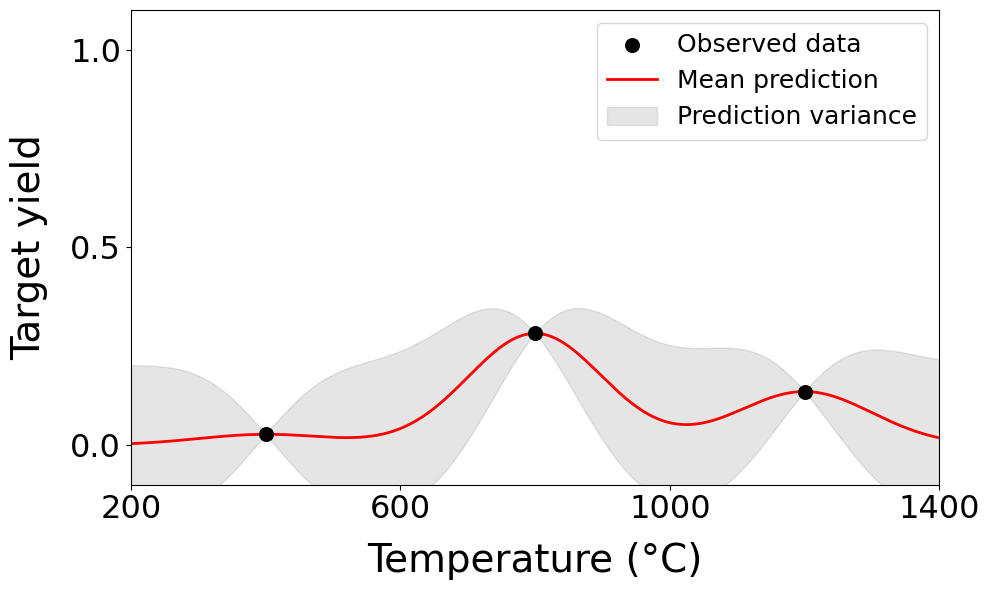

In [749]:
def plot_data(T, target_yield, mu_s, cov_s, stdv, temp_range, show_legend=True):
    """
    T: temperatures that we have sampled
    target_yield: observed yield at those temperatures
    mu_s: mean predictions from my GP model
    cov_s: covariance across the domain
    stdv: standard deviation of the GP model's predictions
    temp_range: domain of temperature we are working in
    """

    # Plotting the mean and variance (as shaded region)
    plt.figure(figsize=(10, 6))

    plt.scatter(T, target_yield, color='black', zorder=5, s=96, label='Observed data')

    # Plot the mean line
    plt.plot(temp_range, mu_s, 'r', lw=2, label='Mean prediction')

    # Add shaded region for the variance
    plt.fill_between(temp_range, mu_s - 0.2*stdv, mu_s + 0.2*stdv, color='gray', alpha=0.2, label='Prediction variance')

    # Formatting info
    plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
    plt.ylabel('Target yield', fontsize=28, labelpad=16)
    plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
    plt.yticks([0, 0.5, 1.0], fontsize=23)
    plt.xlim(2.0, 14.0)
    plt.ylim(-0.1, 1.1)

    if show_legend:
        plt.legend(prop={'size': 18}, loc='upper right')

    plt.tight_layout()
    plt.show()

plot_data(T, target_yield, mu_s, cov_s, stdv, temp_range)

Looking at this plot, our target yield is still quite low, and the model is highly uncertain in much of the domain.

This means we need more data...But where? To answer this, we should compute the acquisition function.

Here we'll use the upper confidence bound (UCB) acquisition function.

In [751]:
# Define the UCB acquisition function
def upper_conf_bound(mu_s, std_s, beta):
    """
    mu_s: mean predictions
    std_s: uncertainty of those predictions
    beta: controls exploration/exploitation tradeoff
    """

    # Exploration versus exploitation
    ucb = mu_s + (beta * std_s)
    return ucb

beta = 1.0
acq_fn = upper_conf_bound(mu_s, stdv, beta)

Remember that $\beta$ controls the exploration/exploitation tradeoff. Larger values of $\beta$ lead to more exploration of highly uncertain areas, whereas smaller values lead to more exploitation around areas where the target yield is expected to be high.

For now, we'll use $\beta = 1$. Let's plot the acquisition function to see what this tells us. 

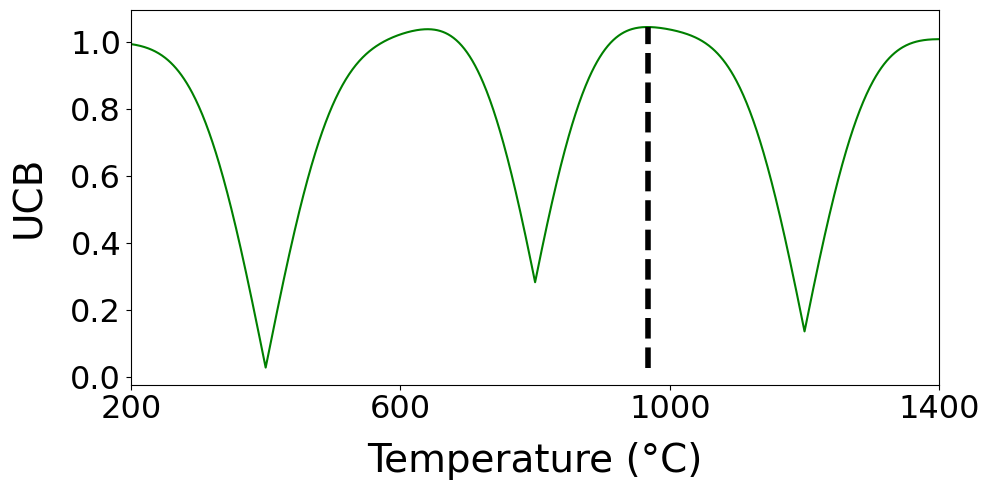

9.67


In [752]:
def plot_acq(temp_range, acq_fn, show=True):

    # Find max of acq function
    max_ind = np.argmax(acq_fn)
    next_T = temp_range[max_ind]

    if show:

        # Plotting the acqusition function
        plt.figure(figsize=(10, 5))

        plt.plot(temp_range, acq_fn, 'g-')

        # Plot vertical line at max
        plt.plot([next_T, next_T], [min(acq_fn), max(acq_fn)], color='k', linestyle='dashed', linewidth=4)

        # Formatting info
        plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
        plt.ylabel('UCB', fontsize=28, labelpad=16)
        plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
        plt.yticks(fontsize=23)
        plt.xlim(2.0, 14.0)

        plt.tight_layout()
        plt.show()

    return next_T

next_T = plot_acq(temp_range, acq_fn)
print(next_T)

The maximum of the acquisition function tells us where to sample next. In this case, we should perform our next experiment at a temperature of about 950 degrees C.

Below we will simulate this experiment, collect a new datapoint, and retrain our Gaussian process model.

In [753]:
# Sample next datapoint
T = np.append(T, next_T)
target_yield = np.append(target_yield, perform_exp(next_T))

# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

Which yields a new model and acquisition function, plotted below.

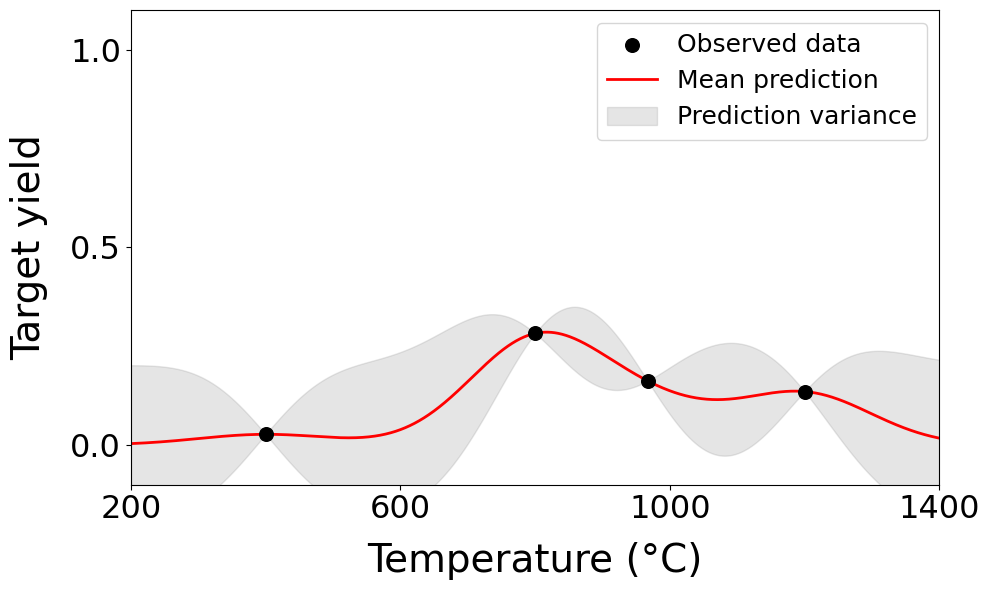

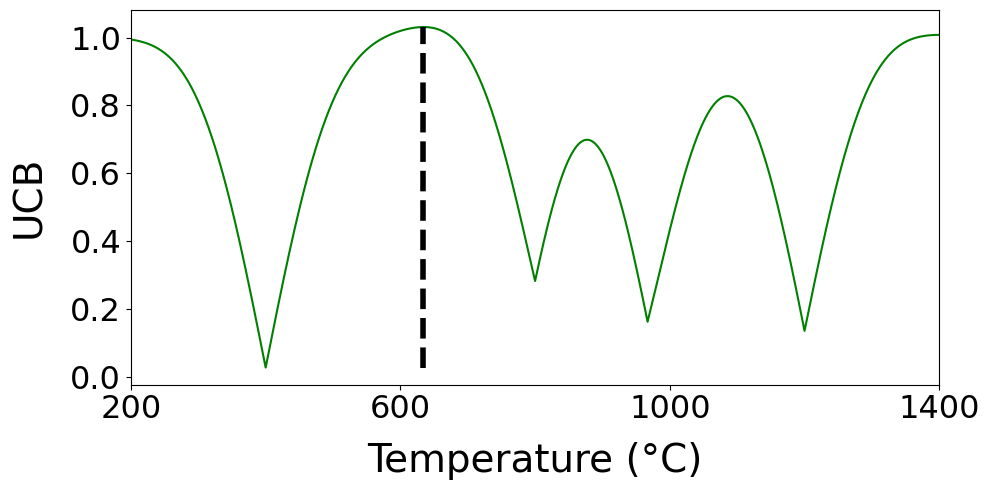

In [754]:
plot_data(T, target_yield, mu_s, cov_s, stdv, temp_range)

acq_fn = upper_conf_bound(mu_s, stdv, beta)

next_T = plot_acq(temp_range, acq_fn)

This gives us another temperature at which to collect new data.

Let's iterate a few more times

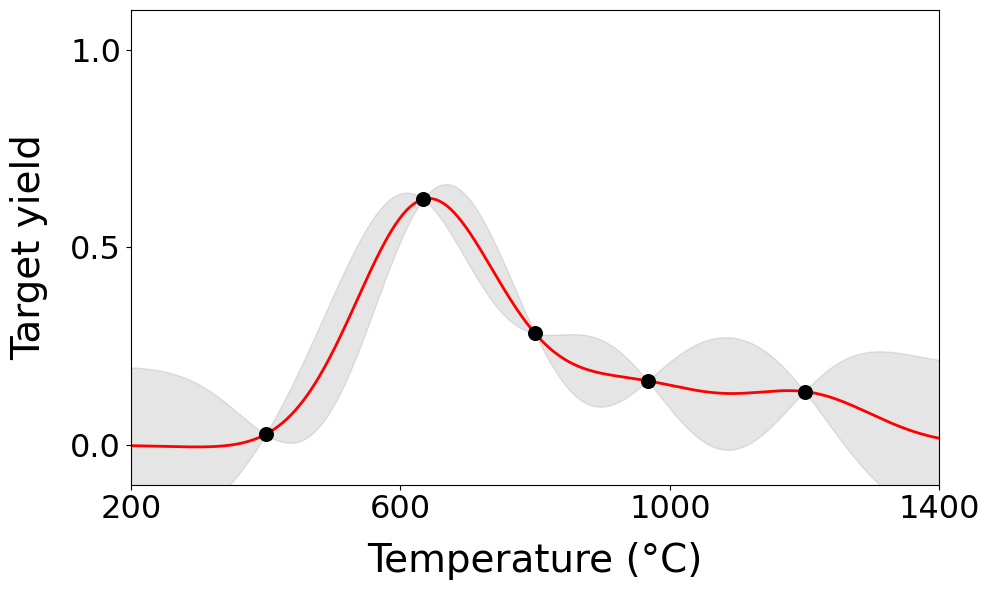

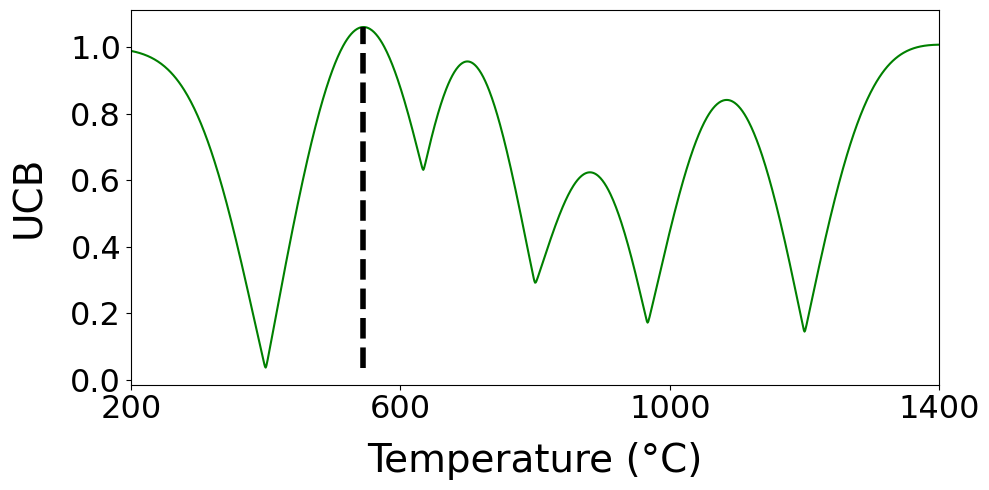

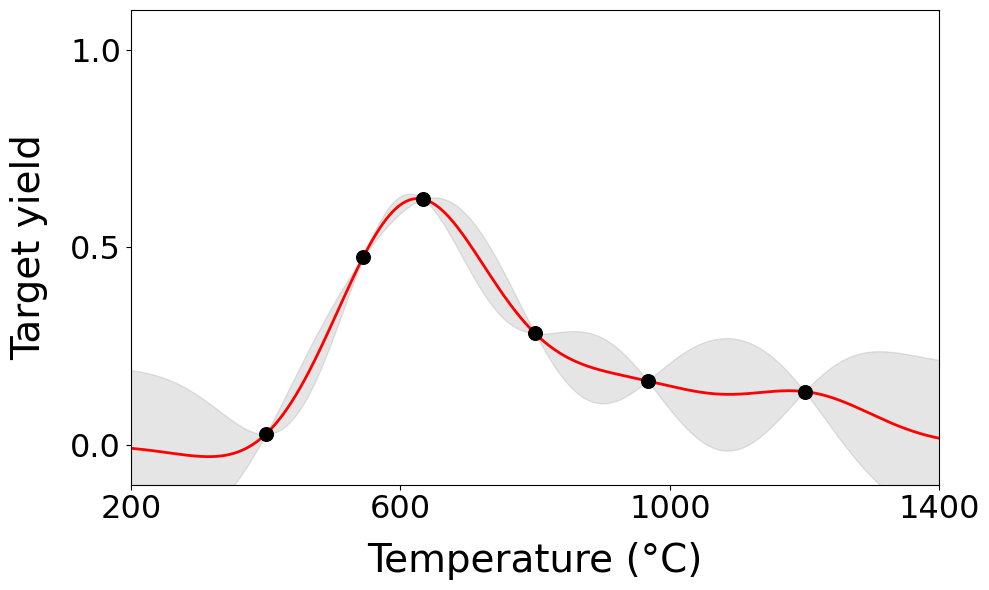

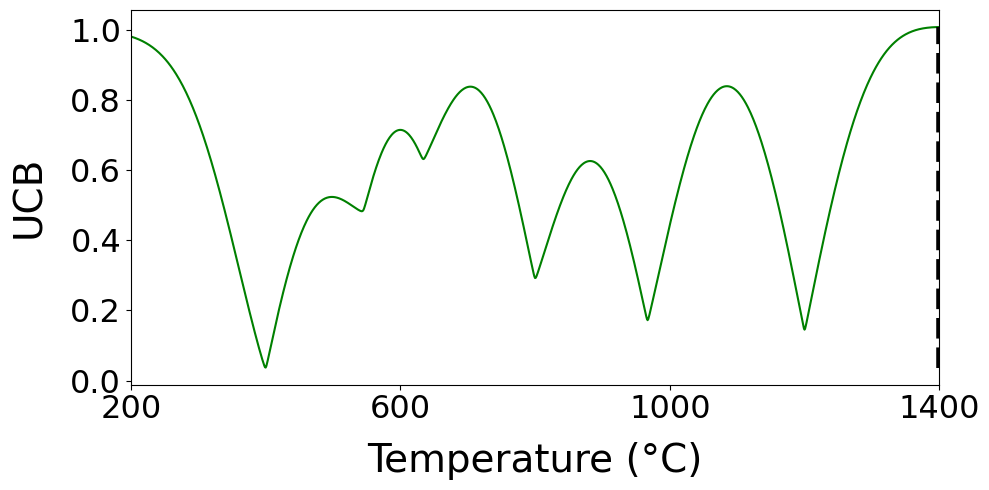

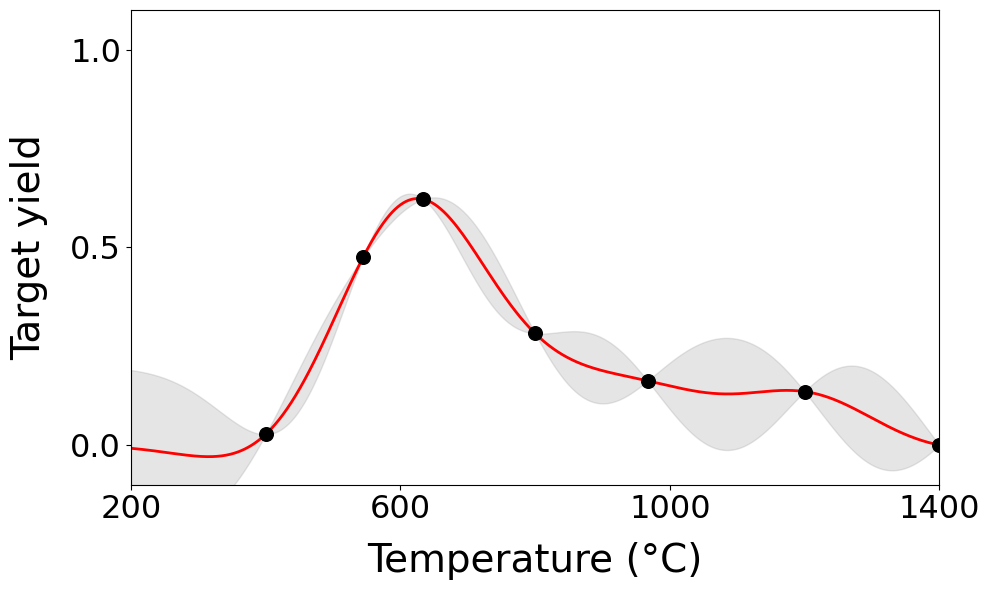

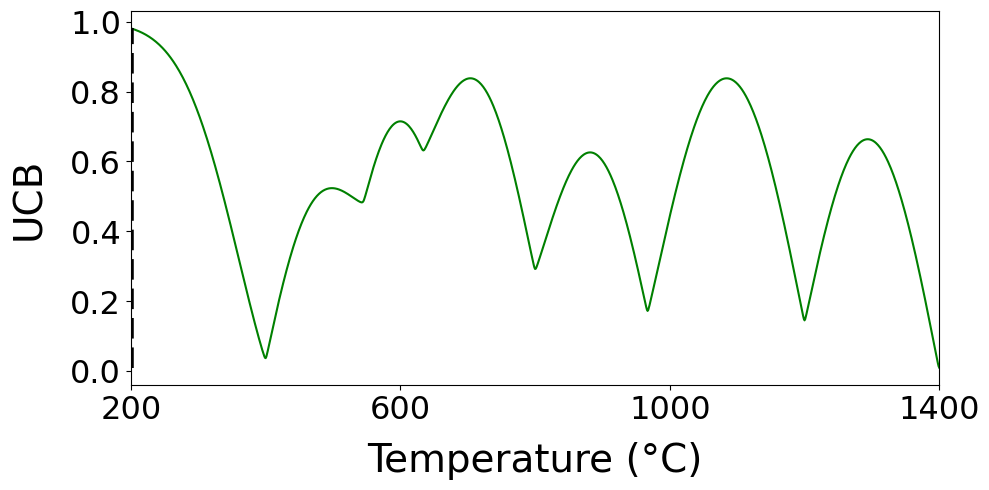

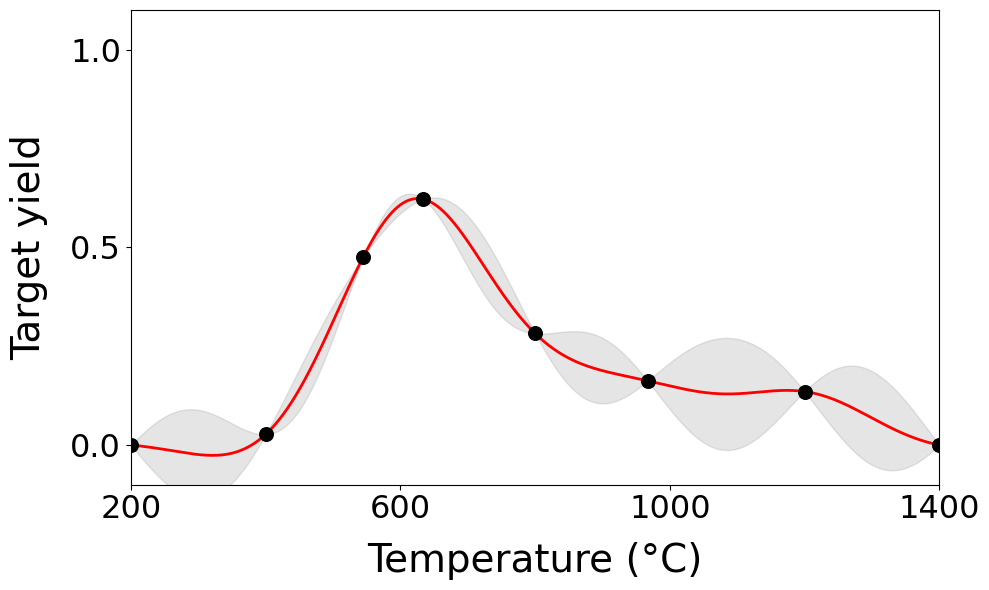

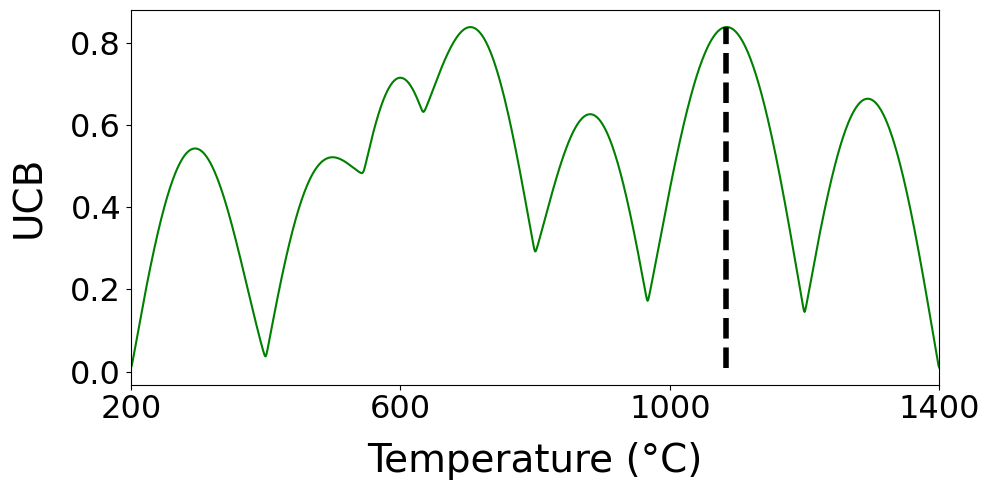

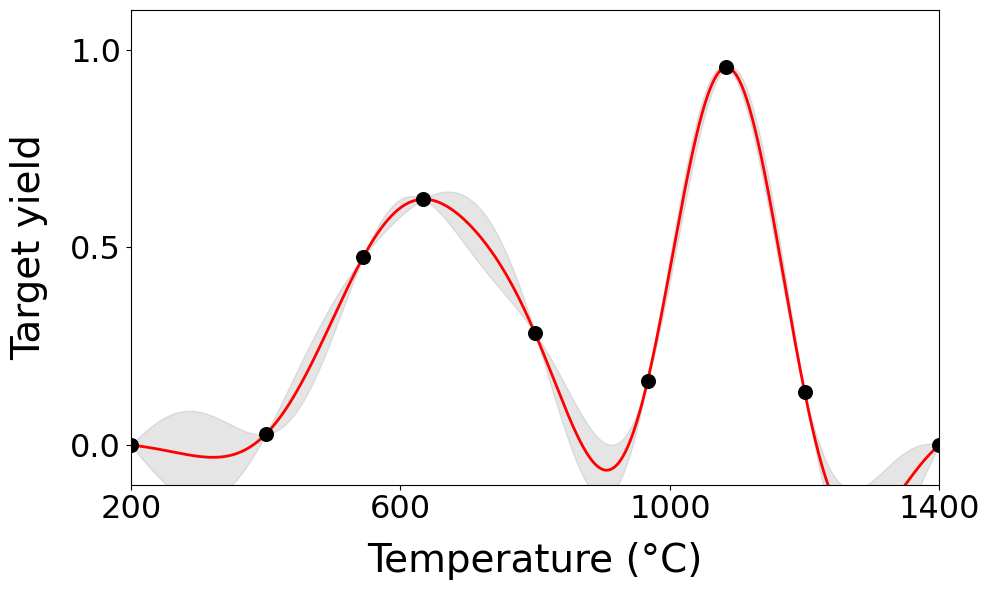

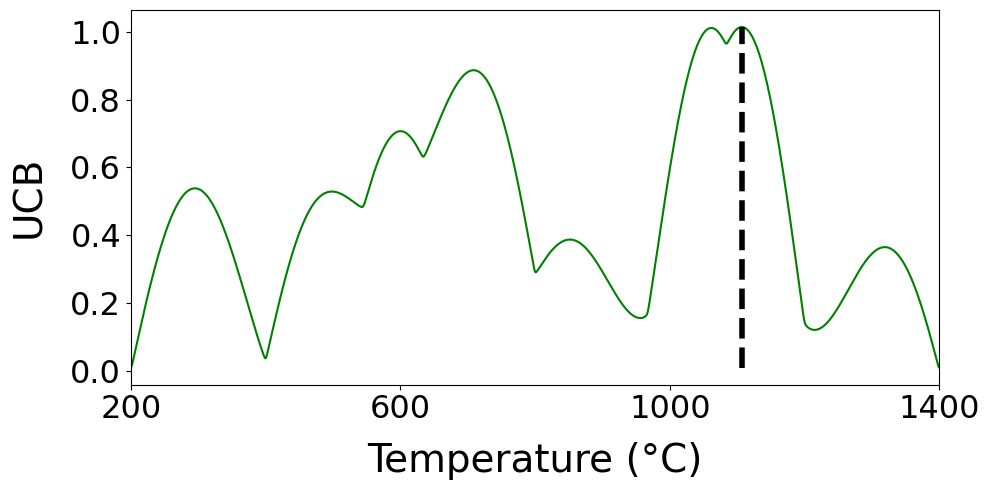

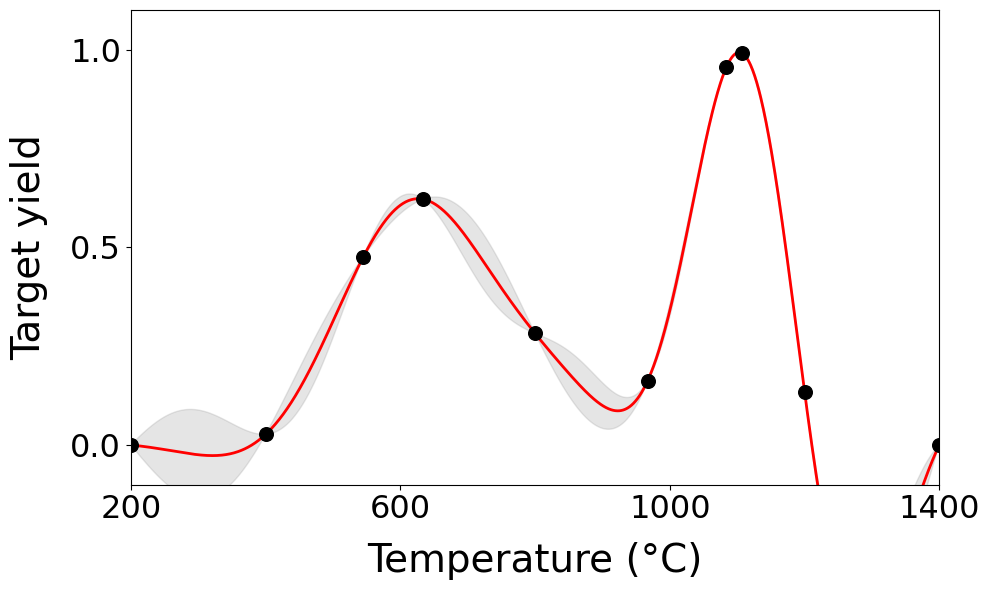

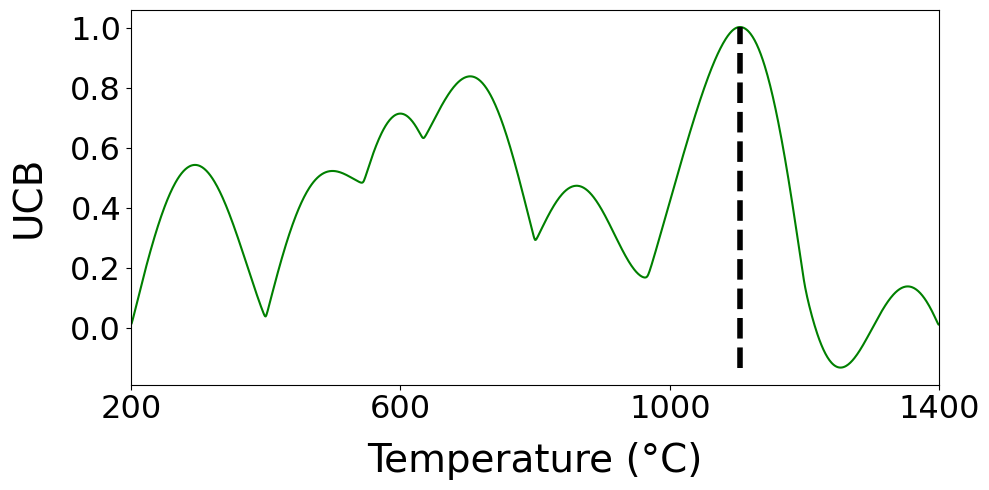

In [755]:
# Iteratively repeat this process
num_iter = 6
for i in range(num_iter):

    # Sample next datapoint
    T = np.append(T, next_T)
    target_yield = np.append(target_yield, perform_exp(next_T))

    # Kernel of the temperature data
    K = rbf_kernel(T, T)  + 1e-4 * np.eye(len(T)) # Add small number for numerical stability

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel(T, temp_range)
    K_ss = rbf_kernel(temp_range, temp_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    plot_data(T, target_yield, mu_s, cov_s, stdv, temp_range, show_legend=False)

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_T = plot_acq(temp_range, acq_fn)

It seems we have converged to a maximum in the target yield around 1100 degrees C. Is this reasonable? Let's compare it with the "true" function.

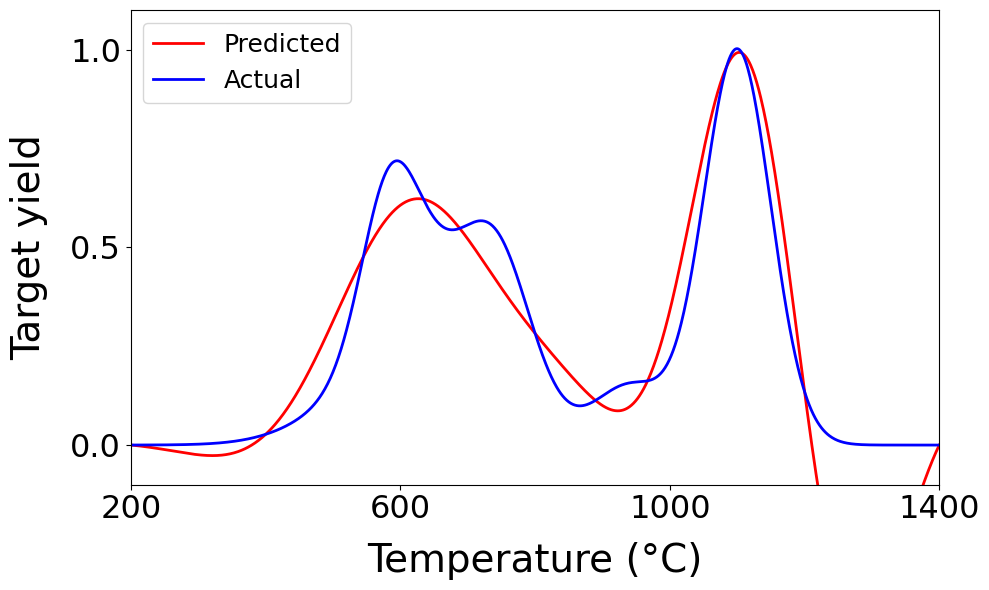

In [756]:
true_yield = [perform_exp(each_T) for each_T in temp_range]

# Plotting the mean and variance (as shaded region)
plt.figure(figsize=(10, 6))


# Plot the mean line for the predicted yield
plt.plot(temp_range, mu_s, 'r', lw=2, label='Predicted')

# Plot the actual yield
plt.plot(temp_range, true_yield, 'b', lw=2, label='Actual')

# Formatting info
plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
plt.ylabel('Target yield', fontsize=28, labelpad=16)
plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
plt.yticks([0, 0.5, 1.0], fontsize=23)
plt.xlim(2.0, 14.0)
plt.ylim(-0.1, 1.1)

plt.legend(prop={'size': 18}, loc='upper left')

plt.tight_layout()
plt.show()


The fit of our predicted model is generally reasonable, with some disagreement in areas of low target yield. These are the parts of the domain that were undersampled since we care mostly about maximizing the yield.

Importantly, the model is accurate around the true maximum in target yield. So our Bayesian optimization campaign was a success!

## The importance of setting a reasonable prior

Recall that we defined our covariance as the RBF kernel with a correlation length of 1.0, corresponding to 100 degrees C.

What if we instead believed our target yield should vary less with temperature? In this case, we would use a larger correlation length.

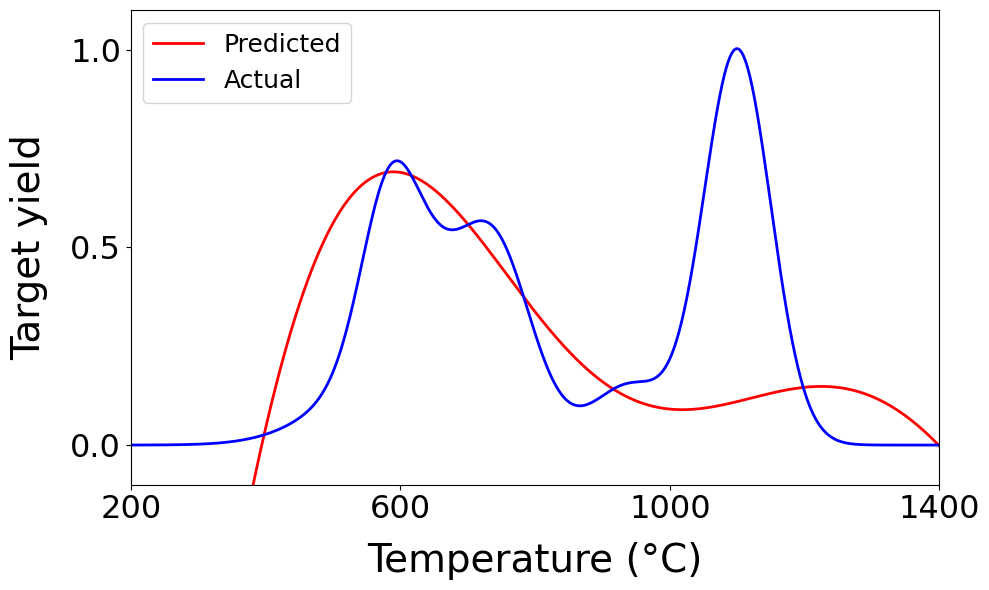

In [757]:
# RBF kernel function with a correlation length of 5.0 (500 degrees C)
def rbf_kernel(x1, x2, length_scale=5.0):
    return np.exp(-0.5 * np.subtract.outer(x1, x2)**2 / length_scale**2)

# Initial experiments
T = np.array([400., 800., 1200.])
T /= 100.0
target_yield = np.array([perform_exp(temp) for temp in T])

# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_T = plot_acq(temp_range, acq_fn, show=False)

# Iteratively repeat this process
num_iter = 6
for i in range(num_iter):

    # Sample next datapoint
    T = np.append(T, next_T)
    target_yield = np.append(target_yield, perform_exp(next_T))

    # Kernel of the temperature data
    K = rbf_kernel(T, T)  + 1e-4 * np.eye(len(T)) # Add small number for numerical stability

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel(T, temp_range)
    K_ss = rbf_kernel(temp_range, temp_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_T = plot_acq(temp_range, acq_fn, show=False)

# Plotting the mean and variance (as shaded region)
plt.figure(figsize=(10, 6))

# Plot the mean line for the predicted yield
plt.plot(temp_range, mu_s, 'r', lw=2, label='Predicted')

# Plot the actual yield
plt.plot(temp_range, true_yield, 'b', lw=2, label='Actual')

# Formatting info
plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
plt.ylabel('Target yield', fontsize=28, labelpad=16)
plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
plt.yticks([0, 0.5, 1.0], fontsize=23)
plt.xlim(2.0, 14.0)
plt.ylim(-0.1, 1.1)

plt.legend(prop={'size': 18}, loc='upper left')

plt.tight_layout()
plt.show()

Not a good result. Our predicted model is much too smooth! It completely misses the high-temperature mode.

On the other hand, what if we assume less correlation?

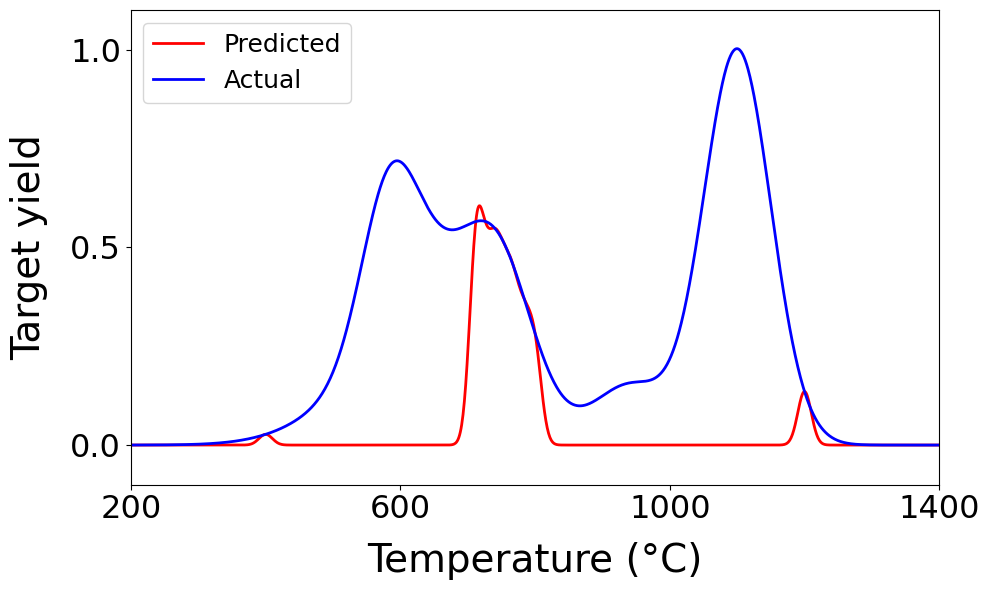

In [758]:
# RBF kernel function with a correlation length of 0.1 (10 degrees C)
def rbf_kernel(x1, x2, length_scale=0.1):
    return np.exp(-0.5 * np.subtract.outer(x1, x2)**2 / length_scale**2)

# Initial experiments
T = np.array([400., 800., 1200.])
T /= 100.0
target_yield = np.array([perform_exp(temp) for temp in T])

# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_T = plot_acq(temp_range, acq_fn, show=False)

# Iteratively repeat this process
num_iter = 6
for i in range(num_iter):

    # Sample next datapoint
    T = np.append(T, next_T)
    target_yield = np.append(target_yield, perform_exp(next_T))

    # Kernel of the temperature data
    K = rbf_kernel(T, T)  + 1e-4 * np.eye(len(T)) # Add small number for numerical stability

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel(T, temp_range)
    K_ss = rbf_kernel(temp_range, temp_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_T = plot_acq(temp_range, acq_fn, show=False)

# Plotting the mean and variance (as shaded region)
plt.figure(figsize=(10, 6))

# Plot the mean line for the predicted yield
plt.plot(temp_range, mu_s, 'r', lw=2, label='Predicted')

# Plot the actual yield
plt.plot(temp_range, true_yield, 'b', lw=2, label='Actual')

# Formatting info
plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
plt.ylabel('Target yield', fontsize=28, labelpad=16)
plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
plt.yticks([0, 0.5, 1.0], fontsize=23)
plt.xlim(2.0, 14.0)
plt.ylim(-0.1, 1.1)

plt.legend(prop={'size': 18}, loc='upper left')

plt.tight_layout()
plt.show()


Also not good! Without accounting for the correlation that exists between nearby temperatures, we don't sample a wide enough range to find the maximum.

In summary: it is important to choose a reasonable prior based on how much correlation you expect in the data.

## The importance of balancing exploration with exploitation

Recall that we set $\beta = 1$ in our acquisition function, which provides a reasonable tradeoff between exploration and exploitation.

What if instead decided to ignore exploitation (large $\beta$) and instead place all our focus on optimizing the model's overall accuracy?

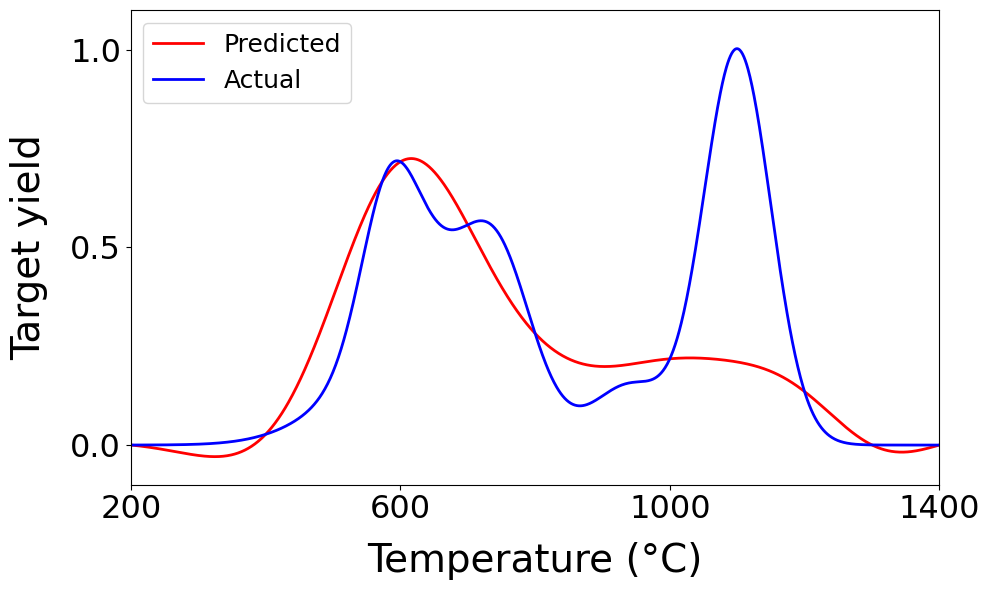

In [759]:
# RBF kernel function with a correlation length of 1.0
def rbf_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * np.subtract.outer(x1, x2)**2 / length_scale**2)

# Initial experiments
T = np.array([400., 800., 1200.])
T /= 100.0
target_yield = np.array([perform_exp(temp) for temp in T])

# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
beta = 100.0 # Favor exploration
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_T = plot_acq(temp_range, acq_fn, show=False)

# Iteratively repeat this process
num_iter = 6
for i in range(num_iter):

    # Sample next datapoint
    T = np.append(T, next_T)
    target_yield = np.append(target_yield, perform_exp(next_T))

    # Kernel of the temperature data
    K = rbf_kernel(T, T)  + 1e-4 * np.eye(len(T)) # Add small number for numerical stability

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel(T, temp_range)
    K_ss = rbf_kernel(temp_range, temp_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_T = plot_acq(temp_range, acq_fn, show=False)

# Plotting the mean and variance (as shaded region)
plt.figure(figsize=(10, 6))

# Plot the mean line for the predicted yield
plt.plot(temp_range, mu_s, 'r', lw=2, label='Predicted')

# Plot the actual yield
plt.plot(temp_range, true_yield, 'b', lw=2, label='Actual')

# Formatting info
plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
plt.ylabel('Target yield', fontsize=28, labelpad=16)
plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
plt.yticks([0, 0.5, 1.0], fontsize=23)
plt.xlim(2.0, 14.0)
plt.ylim(-0.1, 1.1)

plt.legend(prop={'size': 18}, loc='upper left')

plt.tight_layout()
plt.show()


In doing so, we fail to exploit the maximum around 1100 C.

On the other hand, what if we favor exploitation (small $\beta$) over exploration?

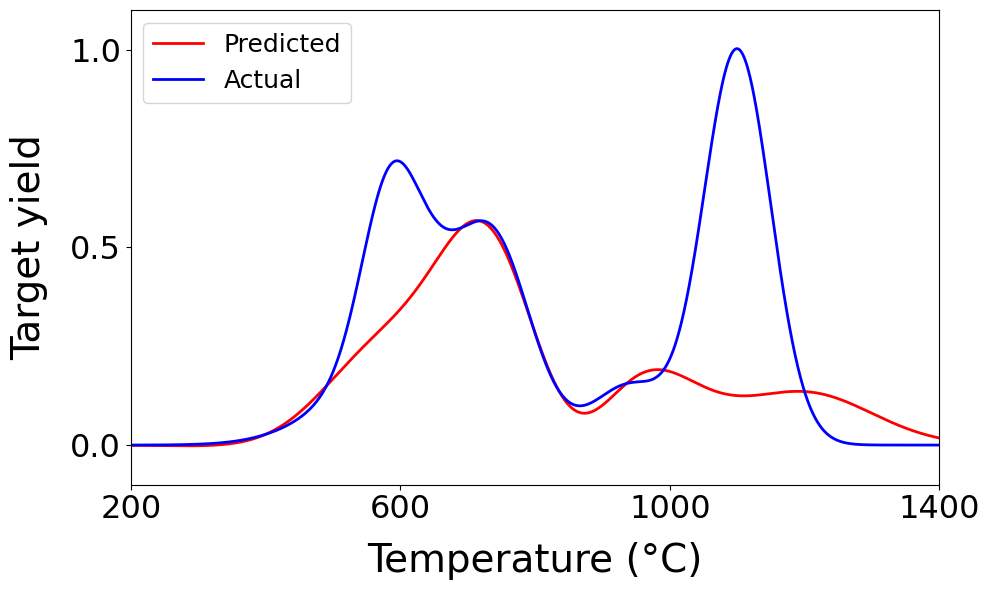

In [760]:
# RBF kernel function with a correlation length of 1.0
def rbf_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * np.subtract.outer(x1, x2)**2 / length_scale**2)

# Initial experiments
T = np.array([400., 800., 1200.])
T /= 100.0
target_yield = np.array([perform_exp(temp) for temp in T])

# Kernel of the temperature data
K = rbf_kernel(T, T)

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel(T, temp_range)
K_ss = rbf_kernel(temp_range, temp_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
beta = 0.1 # Favor exploitation
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_T = plot_acq(temp_range, acq_fn, show=False)

# Iteratively repeat this process
num_iter = 6
for i in range(num_iter):

    # Sample next datapoint
    T = np.append(T, next_T)
    target_yield = np.append(target_yield, perform_exp(next_T))

    # Kernel of the temperature data
    K = rbf_kernel(T, T)  + 1e-4 * np.eye(len(T)) # Add small number for numerical stability

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel(T, temp_range)
    K_ss = rbf_kernel(temp_range, temp_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_T = plot_acq(temp_range, acq_fn, show=False)

# Plotting the mean and variance (as shaded region)
plt.figure(figsize=(10, 6))

# Plot the mean line for the predicted yield
plt.plot(temp_range, mu_s, 'r', lw=2, label='Predicted')

# Plot the actual yield
plt.plot(temp_range, true_yield, 'b', lw=2, label='Actual')

# Formatting info
plt.xlabel('Temperature (°C)', fontsize=28, labelpad=12)
plt.ylabel('Target yield', fontsize=28, labelpad=16)
plt.xticks([2, 6, 10, 14], ['200', '600', '1000', '1400'], fontsize=23)
plt.yticks([0, 0.5, 1.0], fontsize=23)
plt.xlim(2.0, 14.0)
plt.ylim(-0.1, 1.1)

plt.legend(prop={'size': 18}, loc='upper left')

plt.tight_layout()
plt.show()


In this case, we get stuck in a local maxima, and we don't explore enough to find the true maximum at higher temperature.

To summarize: both exploration and exploitation are needed to perform a successful optimization!

# Example 2: Bayesian optimization of a chemical reaction in two dimensions

In the previous example, we only optimized the target yield with respect to one variable: reaction temperature ($T$). But in principle, we can do Bayesian optimization in an arbitrary number of dimensions.

For the current example, suppose you are now optimizing the target yield with respect to the concentration of two precursors: $c_{1}$ and $c_{2}$. Our goal is to once again maximize the target yield in as few experimental iterations as possible.

Let's again define the "black box" function that we will be querying.

In [761]:
def perform_exp(c1, c2):
    # Target yield is modeled as a sum of 2D Gaussians
    # Each Gaussian is defined by amplitude, mean1, mean2, std_dev1, std_dev2
    params = [
        (0.9, 0.8, 0.9, 0.2, 0.6),  # (amplitude, mean1, mean2, std_dev1, std_dev2)
        (0.8, 0.1, 0.35, 0.3, 0.4),
        (0.65, 0.8, 0.1, 0.3, 0.1),
    ]

    # Initialize the yield
    target_yield = 0

    # Summing the 2D Gaussians
    for amplitude, mean1, mean2, std_dev1, std_dev2 in params:
        exponent = -(((c1 - mean1) ** 2) / (2 * std_dev1 ** 2) + ((c2 - mean2) ** 2) / (2 * std_dev2 ** 2))
        target_yield += amplitude * np.exp(exponent)

    return target_yield

And the domain we plan to work in: $c_{1}$ and $c_{2}$ can each range from 0 to 1.

In [762]:
# Domain over which we will operate
c1 = np.linspace(0, 1, 101)
c2 = np.linspace(0, 1, 101)

# Create a meshgrid for the two-dimensional range
c1_grid, c2_grid = np.meshgrid(c1, c2)

Let's "peak into the black box" and see what the target yield looks like over this domain. Note that in practice, we won't know this beforehand (without running experiments).

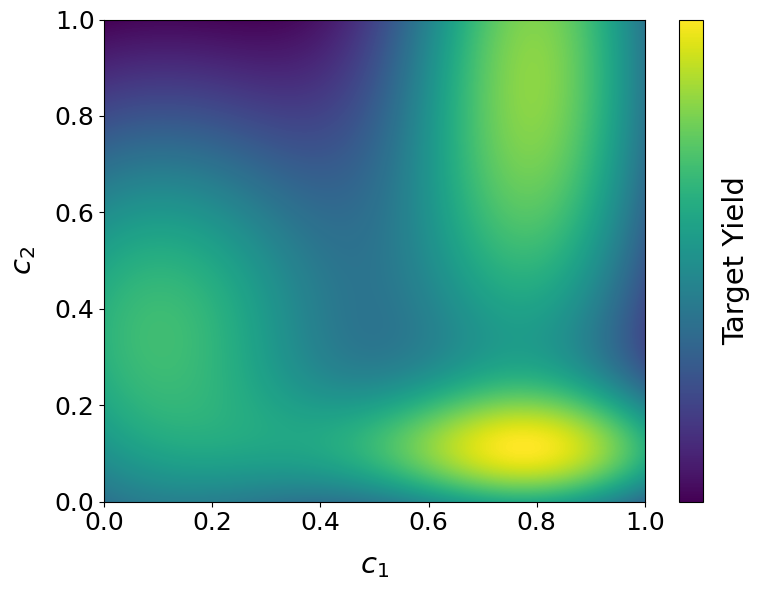

In [763]:
# Calculating target yield for each combination of c1 and c2
all_target_yield = np.zeros((len(c1), len(c2)))
for i, val1 in enumerate(c1):
    for j, val2 in enumerate(c2):
        all_target_yield[i, j] = perform_exp(val1, val2)

# Plotting the heatmap
def plot_heatmap(pts=[]):

    plt.figure(figsize=(8, 6))

    plt.contourf(c1, c2, all_target_yield.T, levels=1000, cmap='viridis')

    # Plot observed datapoints (if any)
    if len(pts) > 0:
        plt.plot([p[0] for p in pts], [p[1] for p in pts], 'ko')

    plt.xlabel('$c_{1}$', fontsize=21, labelpad=12)
    plt.ylabel('$c_{2}$', fontsize=21, labelpad=12)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    cbar = plt.colorbar(label='Target Yield')
    cbar.ax.set_ylabel('Target Yield', fontsize=21, labelpad=14)
    cbar.set_ticks([])

    plt.tight_layout()
    plt.show()

plot_heatmap()

To perform Bayesian optimization over this space, we need to define a new covariance. Let's again use the RBF kernel, but now generalized to higher dimensions.

In [767]:
# RBF kernel function for two-dimensional input
def rbf_kernel_2d(X1, X2, length_scale=0.1): # Correlation length = 0.1
    """
    Compute the RBF kernel between two sets of 2-dimensional vectors.

    X1, X2: Arrays of shape (n_samples_1, 2) and (n_samples_2, 2)
    length_scale: The length scale of the kernel.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

Besides this change, the rest of the optimization can be performed in a similar fashion as the one-dimensional case.

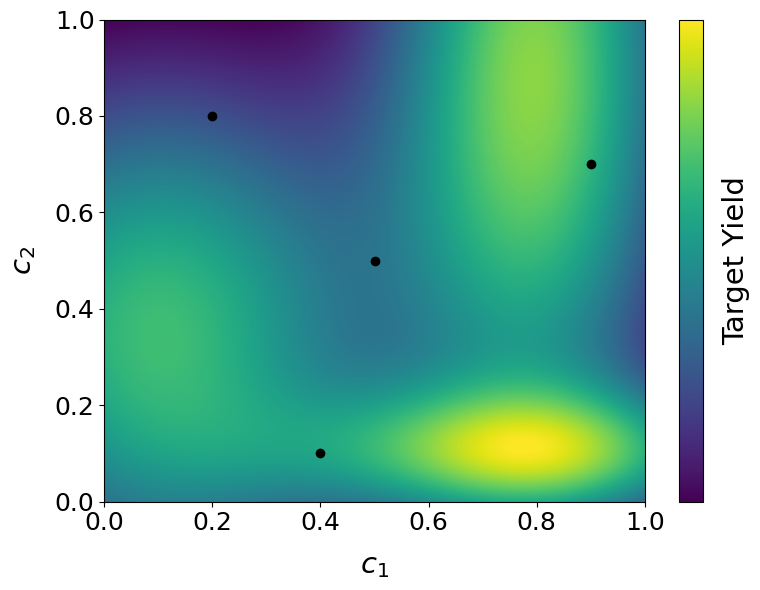

In [768]:
# Initial experiments
c = np.array([(0.2, 0.8), (0.4, 0.1), (0.5, 0.5), (0.9, 0.7)]) # (c1, c2)
target_yield = np.array([perform_exp(*cj) for cj in c])

plot_heatmap(c)

# Reformat domain
c_range = np.vstack([c1_grid.ravel(), c2_grid.ravel()]).T

# Kernel of the observed data
K = rbf_kernel_2d(c, c)

# To improve numerical stability, add a small value to the diagonal
K += np.eye(K.shape[0]) * 1e-6

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel_2d(c, c_range)
K_ss = rbf_kernel_2d(c_range, c_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(np.linalg.inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
beta = 1.0
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_c = plot_acq(c_range, acq_fn, show=False)


Shown above are the initial points sampled in the two-dimensional search space.

What does Bayesian optimization decide to sample next? Below we iteratively sample and retrain our model.

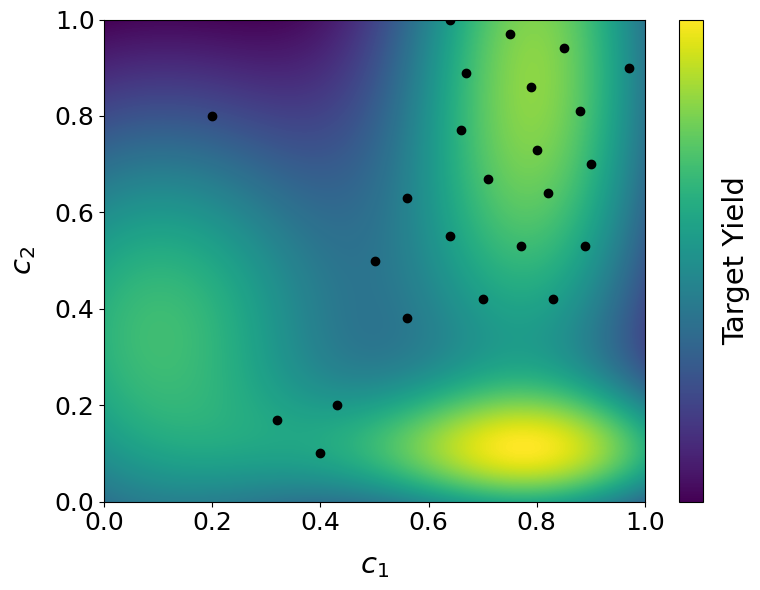

In [769]:
# Iteratively repeat this process
num_iter = 20
for i in range(num_iter):

    # Sample next datapoint
    c = np.concatenate((c, [next_c]), axis=0)
    target_yield = np.append(target_yield, perform_exp(*next_c))

    # Kernel of the observed data
    K = rbf_kernel_2d(c, c)

    # To improve numerical stability, add a small value to the diagonal
    K += np.eye(K.shape[0]) * 1e-6

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel_2d(c, c_range)
    K_ss = rbf_kernel_2d(c_range, c_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(np.linalg.inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_c = plot_acq(c_range, acq_fn, show=False)

plot_heatmap(c)

Looks like we got stuch in some local maximum. What if we retried this campaign with increased exploration?

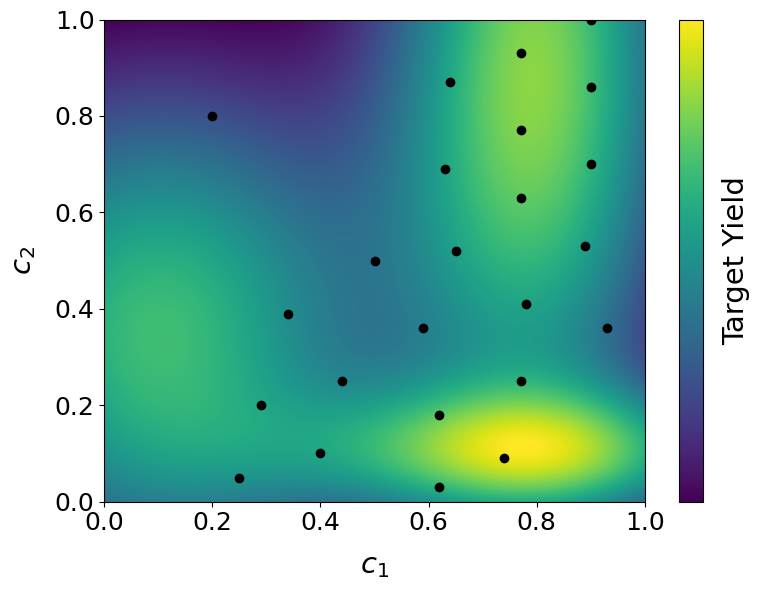

In [770]:
# Initial experiments
c = np.array([(0.2, 0.8), (0.4, 0.1), (0.5, 0.5), (0.9, 0.7)]) # (c1, c2)
target_yield = np.array([perform_exp(*cj) for cj in c])

# Reformat domain
c_range = np.vstack([c1_grid.ravel(), c2_grid.ravel()]).T

# Kernel of the observed data
K = rbf_kernel_2d(c, c)

# To improve numerical stability, add a small value to the diagonal
K += np.eye(K.shape[0]) * 1e-6

# Applying the kernel function to our sampled and unsampled data
K_s = rbf_kernel_2d(c, c_range)
K_ss = rbf_kernel_2d(c_range, c_range)

# Calculating the mean and covariance of the posterior distribution
mu_s = K_s.T.dot(np.linalg.inv(K)).dot(target_yield)
cov_s = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)
stdv = np.sqrt(np.diag(cov_s))

# Compute acquisition function
beta = 2.0 # More exploration
acq_fn = upper_conf_bound(mu_s, stdv, beta)
next_c = plot_acq(c_range, acq_fn, show=False)

# Iteratively repeat this process
num_iter = 20
for i in range(num_iter):

    # Sample next datapoint
    c = np.concatenate((c, [next_c]), axis=0)
    target_yield = np.append(target_yield, perform_exp(*next_c))

    # Kernel of the observed data
    K = rbf_kernel_2d(c, c)

    # To improve numerical stability, add a small value to the diagonal
    K += np.eye(K.shape[0]) * 1e-6

    # Applying the kernel function to our sampled and unsampled data
    K_s = rbf_kernel_2d(c, c_range)
    K_ss = rbf_kernel_2d(c_range, c_range)

    # Calculating the mean and covariance of the posterior distribution
    mu_s = K_s.T.dot(np.linalg.inv(K)).dot(target_yield)
    cov_s = K_ss - K_s.T.dot(np.linalg.inv(K)).dot(K_s)
    stdv = np.sqrt(np.diag(cov_s))

    acq_fn = upper_conf_bound(mu_s, stdv, beta)

    next_c = plot_acq(c_range, acq_fn, show=False)

plot_heatmap(c)


These results are better, as the algorithm explores enough to start sampling near the true maximum.

Ideally, it should now start to exploit the brightest areas of the plot with maximal yield. But this may again depend on the exploration/exploitation balance.

Feel free to play around with the parameters more to see what combination works best!

# Simplifying the process using sklearn

The examples provided above were solved using our own user-defined functions for the surrogate model, covariance, and acquisition function. But luckily, sklearn has built-in capabilities to streamline this process.

Below shows how you can solve Example 1 by using sklearn functions.

First, let's borrow the code from earlier that defines Example 1.

In [772]:
def perform_exp(temperature):

    # Target yield is modeled as a sum of Gaussians
    params = [
        (0.2, 6, 1.0),  # (amplitude, mean, standard deviation)
        (0.3, 5.8, 0.40),
        (0.25, 6.2, 0.55),
        (0.45, 7.4, 0.55),
        (0.15, 9.4, 0.55),
        (1.0, 11, 0.5),
    ]

    # Initialize the yield
    target_yield = 0

    # Summing the Gaussians
    for amplitude, mean, std_dev in params:
        target_yield += amplitude * np.exp(-((temperature - mean) ** 2) / (2 * std_dev ** 2))

    return target_yield

# Initialize temperature range and experiments
temp_range = np.linspace(200, 1400, 1201) / 100.0
T = np.array([[400.], [800.], [1200.]]) / 100.0 # Shape for fitting
target_yield = np.array([[perform_exp(temp[0])] for temp in T])

Now let's optimize using sklearn capabilities.

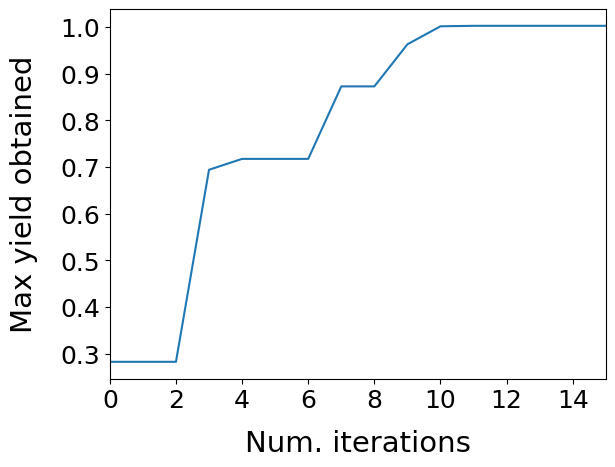

In [773]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import warnings

max_iter = 15
iter_count = 0

max_yield = [max(target_yield)]

# Define the acquisition function
def acquisition_function(x, beta=1.0):
    x = np.array(x).reshape(-1, 1)
    mean, stdv = gp.predict(x, return_std=True)
    return mean + (beta * stdv)
  
# Ignore GP fit warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    while iter_count < max_iter:
        
        kernel = RBF(length_scale=1.0)
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(T, target_yield.ravel())  # Flatten target_yield to 1D for fitting

        # Evaluate and find the maximum of the acquisition function
        acq_values = [acquisition_function(v) for v in temp_range]
        x_next = temp_range[[np.argmax(acq_values)]]
        y_next = perform_exp(x_next[0])

        T = np.vstack((T, [[x_next[0]]]))
        target_yield = np.vstack((target_yield, [[y_next]]))

        current_best_yield = max(target_yield)
        max_yield.append(current_best_yield)

        iter_count += 1

plt.figure()

plt.plot(max_yield)

plt.xlim(0, max_iter)

plt.xlabel('Num. iterations', fontsize=21, labelpad=12)
plt.ylabel('Max yield obtained', fontsize=21, labelpad=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Practice: Optimizing material hardness

Suppose you have have a duralumin alloy which contains three elements: Cu$_{x}$Mg$_{y}$Al$_{1-x-y}$

You aim to maximize the hardness of this material by varying its composition. Accordingly, there are two variables you can tune:
* The concentration of Cu ($x$), which can range from 0-20\%
* The concentration of Mg ($y$), which can range from 0-5\%

But synthesizing an alloy takes a lot of time and energy. So you'd like to achieve maximal hardness with as few experiments as possible.

Below is some code that may help you accomplish this. Play around with it and see how many iterations it takes you to find an alloy with a hardness of 200 HV. 

Check out the [sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) for info on which kernels are available, and [how to use them](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process.kernels).

Running optimization 1/10
Running optimization 2/10
Running optimization 3/10
Running optimization 4/10
Running optimization 5/10
Running optimization 6/10
Running optimization 7/10
Running optimization 8/10
Running optimization 9/10
Running optimization 10/10
Done!
On average, 35 iterations were required to achieve 200 HV
The optimal composition you identified contains 17.8% Cu and 2.6% Mg


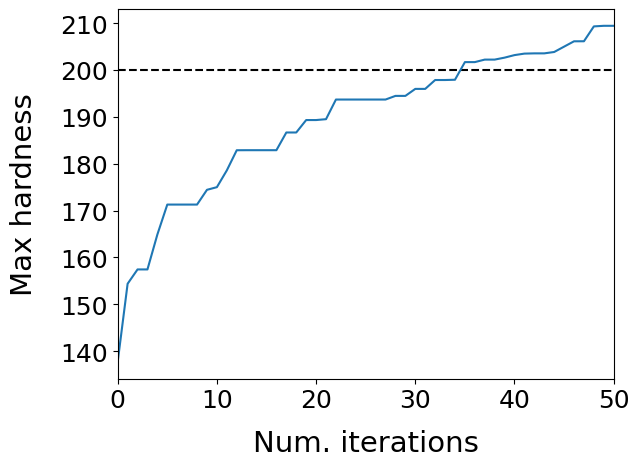

In [781]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import matplotlib.pyplot as plt


"""
User-defined parameters here
"""
kernel = RBF(length_scale=(2, 0.5)) # Choose a covariance function. Hint: you can make the length scale anisotropic.
beta = 1.0 # Exploration/exploitation tradeoff in the acquisition function.

"""
Full code below
"""

def alloy_hardness(c1, c2):

    # Convert to percentages
    c1 /= 100.0
    c2 /= 100.0
    
    # Target yield is modeled as a sum of 2D Gaussians
    # Each Gaussian is defined by amplitude, mean1, mean2, std_dev1, std_dev2
    params = [
        (40, 0.2, 0.01, 0.03, 0.06),  # (amplitude, mean1, mean2, std_dev1, std_dev2)
        (75, 0.1, 0.035, 0.04, 0.04),
        (65, 0.05, 0.01, 0.03,0.01),
        (85, 0.2, 0.02, 0.2,0.01),
        (55, 0.02, 0.045, 0.025,0.005),
        (100, 0.175, 0.03, 0.03,0.01),
    ]

    # Initialize the yield
    hardness = 0

    # Summing the 2D Gaussians
    for amplitude, mean1, mean2, std_dev1, std_dev2 in params:
        exponent = -(((c1 - mean1) ** 2) / (2 * std_dev1 ** 2) + ((c2 - mean2) ** 2) / (2 * std_dev2 ** 2))
        hardness += amplitude * np.exp(exponent)

    return 1.07*hardness

# Define the bounds for Cu and Mg concentration
bounds = np.array([[0, 20], [0, 5]])

# Run the Bayesian optimization
n_iters = 50  # Number of iterations

# We'll run this optimization multiple times
# This mitigates the stochastic nature of it
all_hardness = []
best_composition, best_hardness = (0, 0), 0.0
for j in range(10):

    print('Running optimization %s/10' % (j+1))
    
    # Ignore GP fit warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialize three random samples
        X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], (3, 2))
        Y_sample = alloy_hardness(X_sample[:, 0], X_sample[:, 1]).reshape(-1, 1)  # Reshape Y_sample to be 2D

        max_hardness = [max(Y_sample.flatten())]
        for i in range(n_iters):

            # Define the Gaussian Process model
            gp = GaussianProcessRegressor(kernel=kernel)
        
            # Update the Gaussian process with existing samples
            gp.fit(X_sample, Y_sample)

            # Define the acquisition function
            def acquisition(X):
                mu, sigma = gp.predict(X, return_std=True)
                return mu + (beta * sigma)

            # Find the next sampling point
            X_next = np.random.uniform(bounds[:, 0], bounds[:, 1], (1000, 2))
            Y_next = acquisition(X_next)
        
            # Select the next point to sample
            X_next = X_next[np.argmax(Y_next)]

            # Sample the objective function at the next point
            Y_next = alloy_hardness(X_next[0], X_next[1])

            # Update the samples
            X_sample = np.vstack((X_sample, [X_next]))
            Y_next = np.array([[Y_next]])  # Make Y_next a 2D array with a single element
            Y_sample = np.vstack((Y_sample, Y_next))

            max_hardness.append(max(Y_sample.flatten()))

            if max_hardness[-1] > best_hardness:
                best_hardness = max_hardness[-1]
                best_composition = X_next

        all_hardness.append(max_hardness)

avg_hardness = np.mean(all_hardness, axis=0)

print('Done!')
iter_taken = len([v for v in avg_hardness if v < 200])
print('On average, %s iterations were required to achieve 200 HV' % iter_taken)
print('The optimal composition you identified contains %s%% Cu and %s%% Mg' % (round(best_composition[0], 1), round(best_composition[1], 1)))

plt.figure()

plt.plot([0, n_iters], [200, 200], color='k', linestyle='dashed')

plt.plot(avg_hardness)

plt.xlim(0, n_iters)

plt.xlabel('Num. iterations', fontsize=21, labelpad=12)
plt.ylabel('Max hardness', fontsize=21, labelpad=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Practice: Optimizing a periodic function

Consider a driven but damped harmonic oscillator whose period ($\lambda$) remains fixed ($\lambda = 4$ sec). Your objective is to find the point in time ($t$) where the amplitude of this osciallator's displacement is maximal.

Your physics is rusty, but luckily we can iteratively query the black-box objective function provided below.

In [782]:
def oscillator_displacement(t, A=10, mu=30.0, sigma=14.0):
    return A*np.exp(-((t - mu)**2) / (2 * sigma**2)) * np.sin(np.pi*t/8.)

What is the fewest number of iterations you need to find the time at which point the displacement exceeds 8 m?

Use the code below to answer this question. Hint: you might want to  leverage the prior knowledge we have regarding the periodicity of the oscillator.

Done!
On average, 17 iterations were required to identify 8 m displacement
The time for this displacement is 35.2 sec


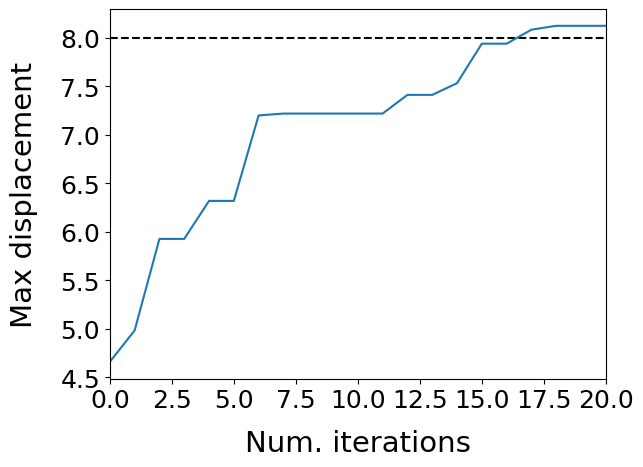

In [783]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from scipy.optimize import minimize
import warnings

"""
User-defined parameters here
"""
kernel = ExpSineSquared(length_scale=5.0, periodicity=16.0) # Choose a kernel
beta = 1.0 # Exploration/exploitation tradeoff in the acquisition function.

"""
Full code below
"""

# We'll run this optimization multiple times
# This mitigates the stochastic nature of it
all_disp = []
best_time = None
for j in range(10):

    # Initialize temperature range and experiments
    time_range = np.linspace(0, 60, 601)
    t = [[np.random.choice(time_range)] for i in range(5)]
    disp = np.array([[oscillator_displacement(time[0])] for time in t])

    max_iter = 20
    iter_count = 0

    max_disp = [max(disp)]

    # Define the acquisition function
    def acquisition_function(x):
        x = np.array(x).reshape(-1, 1)
        mean, stdv = gp.predict(x, return_std=True)
        return mean + (beta * stdv)

    # Ignore GP fit warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        while iter_count < max_iter:
        
            gp = GaussianProcessRegressor(kernel=kernel)
            gp.fit(t, disp.ravel())  # Flatten target_yield to 1D for fitting
            # Random select a starting point for the acquisition function maximization
            starting_point = np.random.choice(time_range)

            # Evaluate and find the maximum of the acquisition function
            acq_values = [acquisition_function(v) for v in time_range]
            x_next = temp_range[[np.argmax(acq_values)]]

            # Avoid suggesting same value
            is_close = lambda val, lst, threshold: any(abs(val - x) < threshold for x in lst)
            is_close(x_next, np.array(t).flatten(), 0.1)
            x_next = [np.random.choice(time_range)]
        
            y_next = oscillator_displacement(x_next[0])

            t = np.vstack((t, [[x_next[0]]]))
            disp = np.vstack((disp, [[y_next]]))

            current_best_disp = max(disp)
            max_disp.append(current_best_disp)

            if max_disp[-1] > max_disp[-2]:
                best_time = x_next[0]
            
            iter_count += 1

        all_disp.append(max_disp)

avg_disp = np.mean(all_disp, axis=0)

print('Done!')
iter_taken = len([v for v in avg_disp if v < 8])
print('On average, %s iterations were required to identify 8 m displacement' % iter_taken)
print('The time for this displacement is %s sec' % round(best_time, 1))


plt.figure()

plt.plot([0, max_iter], [8, 8], color='k', linestyle='dashed')

plt.plot(avg_disp)

plt.xlim(0, max_iter)

plt.xlabel('Num. iterations', fontsize=21, labelpad=12)
plt.ylabel('Max displacement', fontsize=21, labelpad=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# In summary

* Use what you know about your system to build an effective prior!

  - Choose a reasonable correlation length
  - Define your covariance based on expected correlations/trends in your function
  - Choose $\beta$ to ensure a balance of exploration and exploitation...Need to escape local optima!
  - Gaussian processes are not always best. Feel free to try other surrogate models.